# Train a stardist neural network for segmentation

This notebook uses stardist2d and a connect-in-3D strategy to generate labels for training a stardist3D network. 

In [20]:
from skimage.io import imread, imsave
from tnia.plotting.projections import show_xyz_slice, show_xyz_max, show_xy_zy_max, show_xy_zy_slice
from random import randint
import numpy as np
import os
from skimage.measure import label
from tnia.deeplearning.dl_helper import collect_training_data
from stardist import calculate_extents

from tnia.plotting.plt_helper import random_label_cmap
colormap=random_label_cmap()

# Get the list of visible devices and confirm that GPU is available 

... or else training will take a long time

In [2]:
import tensorflow as tf
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define model path

This is the path where the model will be saved, change to be local to your machine

In [3]:
from pathlib import Path
tnia_images_path = Path("D:/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2024_01_30_connect2d_in3d"
model_path = parent_path / 'models'
print(model_path)
patches_path = parent_path / 'patches'
print(patches_path)

D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\models
D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches


# Load the corrupted images and ground truth images

D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches
5

5
5


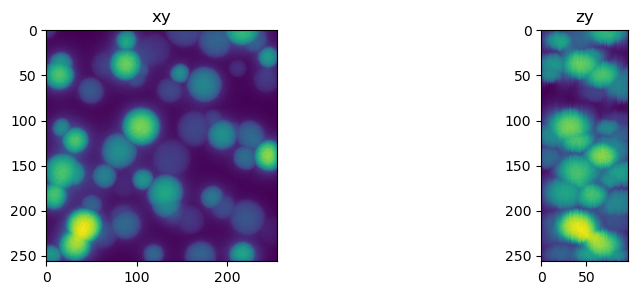

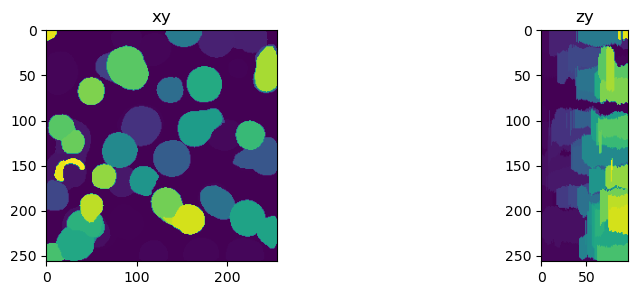

In [4]:
paths = [patches_path]

X = []
Y = []

for path in paths:
    X_, Y_ = collect_training_data(path, sub_sample=1, downsample=False, normalize_truth=False, training_multiple=16)

    print(path)
    print(len(X_))
    print()
    X.extend(X_)
    Y.extend(Y_)

print(len(X))
print(len(Y))

fig = show_xy_zy_max(X[0])
fig = show_xy_zy_max(Y[0])

## Shuffle the datasets

In [7]:
from tnia.deeplearning.dl_helper import shuffle

X, Y = shuffle(X, Y)

X = np.array(X)
Y = np.array(Y).astype(np.uint16)

In [8]:
print(X.max())
print(Y.max())

1.3031219
1274


## Import Stardist

In [9]:
from stardist.models import Config3D, StarDist3D

In [10]:
extents = calculate_extents(Y.squeeze().astype('uint16'))

extents = [80, 20, 20]
anisotropy = tuple(np.max(extents) / extents)
#anisotropy = (3,1,1)

print('extents', extents)
print('anisotropy', anisotropy)

extents [80, 20, 20]
anisotropy (1.0, 4.0, 4.0)


In [13]:
from stardist import Rays_GoldenSpiral
from stardist import Rays_Octo
n_channel_in =1
axes = 'ZYX'

n_rays = 96 

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)
model_name = 'stardist_model_96ray'

#rays = Rays_Octo(n_level=1) 
#model_name = 'stardist_octo'
# create a csbdeep config
# we mostly use the default settings except in this case unet_n_depth=4, so we downsampling 4 times and can use low level features
# consider changing the number of filters (unet_n_first) to save memory

config = Config3D (rays=rays, axes=axes,n_channel_in=1, train_patch_size=(96, 64, 64), grid=(1,2,2), unet_n_depth=3)

#config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=20, train_epochs=50, unet_n_depth=4)
#print(config)
new_model = False 


if new_model:
    #model = StarDist3D(config, name='stardist_model_48ray_combined', basedir=model_path)
    print('initializing new model')
    model = StarDist3D(config, name=model_name, basedir=model_path)
else:
    model = StarDist3D(None,  name=model_name, basedir=model_path)
vars(config)

model3d.py (223): Mismatch of 'anisotropy' of rays and 'anisotropy'.


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 2, 2),
 'anisotropy': None,
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96, 'anisotropy': (1.0, 4.0, 4.0)}},
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (96, 64, 64),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'tra

In [14]:
config.anisotropy, config.grid
median_size = calculate_extents(Y[1:2], np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [32. 33. 34.]
network field of view :  [32 64 64]


In [15]:
X_train=X
Y_train=Y
X_val=X
Y_val=Y


In [18]:
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=50, steps_per_epoch=100)

Epoch 1/50
Cause: Unable to locate the source code of <function _gcd_import at 0x000001A62AFD13A0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x000001A62AFD13A0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate t

In [38]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((5, 96, 256, 256, 1),
 (5, 96, 256, 256),
 (5, 96, 256, 256, 1),
 (5, 96, 256, 256))

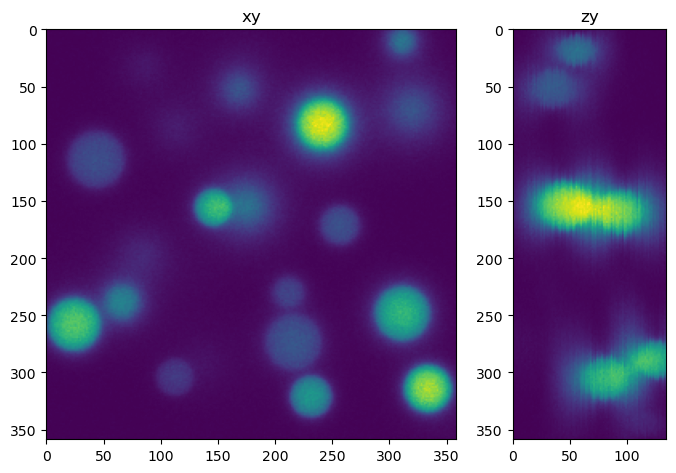

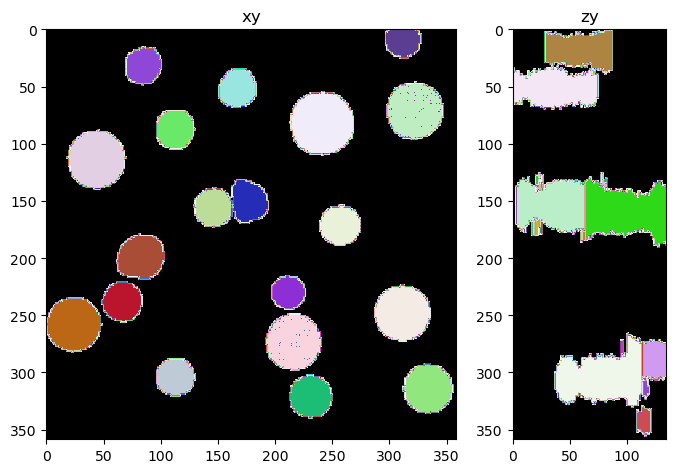

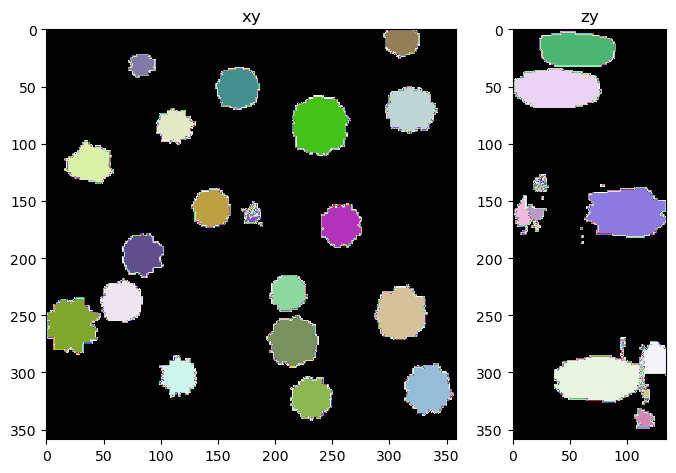

In [23]:
n=2
labels, details = model.predict_instances(X_train[n], prob_thresh=0.3, nms_thresh=0.2)
fig = show_xy_zy_slice(X_train[n], int(X_train[0].shape[2]/2), int(X_train[0].shape[1]/2), 10,1.4,1.4, figsize=(8,6))
fig = show_xy_zy_slice(Y_train[n], int(Y_train[0].shape[2]/2), int(Y_train[0].shape[1]/2), 10,1.4,1.4, colormap=colormap, figsize=(8,6))
fig = show_xy_zy_slice(labels, int(labels.shape[2]/2), int(labels.shape[1]/2), 10,1.4,1.4, colormap=colormap, figsize=(8,6))

In [25]:
X_train[n].shape

(16, 128, 128, 1)

In [22]:
import napari
viewer = napari.Viewer()
viewer.add_image(X_train[n].squeeze())
viewer.add_labels(labels)
viewer.add_labels(Y_train[n].squeeze())
viewer.show()

In [17]:
X_train[n].shape, X_train[n].min(), X_train[n].max()

((96, 256, 256, 1), -0.009466953, 1.2167182)

In [25]:
X_train[0].max()

1.2449049